In [121]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import pathlib
import datetime
from keras import layers, initializers
from keras.utils.vis_utils import plot_model

from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from IPython.display import clear_output, display

In [122]:
# from google.colab import drive
# drive.mount('/content/drive')

In [123]:
PATH_TEST = "./data/test/"
PATH_DEVEL = "./data/validation/"
PATH_TRAIN = "./data/train/"
PATH_GENERATOR = "./generator/"

In [124]:
# The facade training set consist of 400 images
BUFFER_SIZE = 100
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

# Loading the data

In [125]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  input_image = image[:, :w, :]
  real_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Text(0.5, 1.0, 'real image')

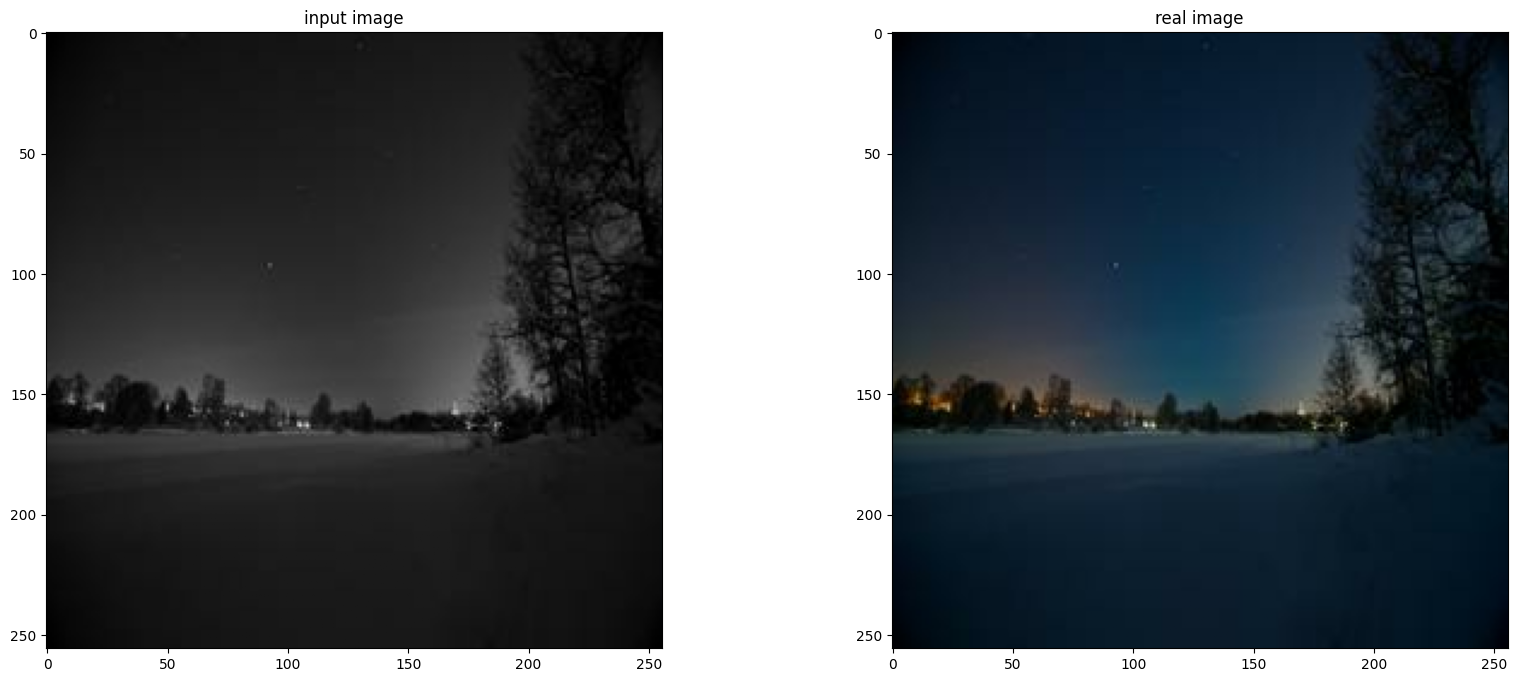

In [126]:
inp, re = load(PATH_TRAIN + '00000001.jpg')

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,8))
ax1.imshow(inp/255.0)
ax1.set_title('input image')
ax2.imshow(re/255.0)
ax2.set_title('real image')

# Pre-processing the data
* normalize to [-1, 1]
* resize to IMG_HEIGHT and IMG_WIDTH
* random cut
* random jitter (*random jitter*):
   * In this process, as mentioned in the paper, the image is resized to a larger size, then a random cut of the original size is made and then a horizontal flip is also made randomly. Below are 4 examples.

In [127]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [128]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [129]:
# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [130]:
@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

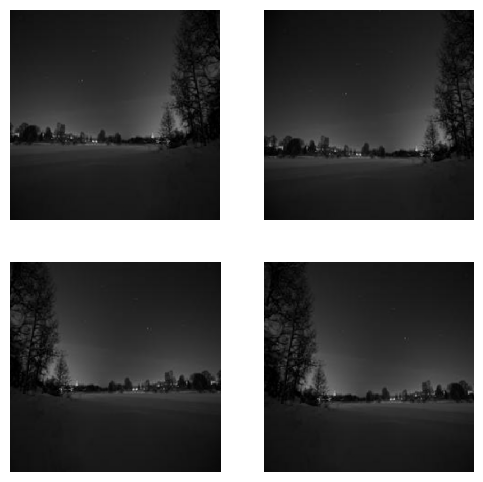

In [131]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i+1)
  plt.imshow(rj_inp/255.0)
  plt.axis('off')
plt.show()

In [132]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [133]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [134]:
train_dataset = tf.data.Dataset.list_files(PATH_TRAIN+'*.jpg')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [135]:
val_dataset = tf.data.Dataset.list_files(PATH_DEVEL+'*.jpg')
val_dataset = val_dataset.map(load_image_test)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [136]:
test_dataset = tf.data.Dataset.list_files(PATH_TEST+'*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Building the generator

In [137]:
OUTPUT_CHANNELS = 3

In [138]:
# Encoder: Convolution -> Batch normalization -> Leaky ReLu
def downsample(filt, size, apply_batchnorm=True):
  init = initializers.RandomNormal(mean=0,stddev=0.02)

  res = keras.Sequential()
  res.add(layers.Conv2D(filt, size, strides=2, padding='same', kernel_initializer=init, use_bias=False))
  res.add(layers.BatchNormalization()) if apply_batchnorm else None
  res.add(layers.LeakyReLU())
  return res

# Decoder: Transposed convolution -> Batch normalization -> 
#           -> Dropout (applied to the first 3 blocks) -> ReLU
def upsample(filt, size, apply_dropout=False):
  init = initializers.RandomNormal(mean=0,stddev=0.02)

  res = keras.Sequential()
  res.add(layers.Conv2DTranspose(filt, size, strides=2, padding='same', kernel_initializer=init,use_bias=False))
  res.add(layers.BatchNormalization())
  res.add(layers.Dropout(0.5)) if apply_dropout else None
  res.add(layers.ReLU())
  return res


In [139]:
def Generator():
  init = tf.random_normal_initializer(0., 0.02)

  # input
  input = layers.Input(shape=[256, 256, 3])

  # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  
    downsample(128, 4), 
    downsample(256, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4),  
    downsample(512, 4), 
  ]

  # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
  up_stack = [
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4), 
    upsample(256, 4), 
    upsample(128, 4),  
    upsample(64, 4),  
  ]

  # output
  last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=init, activation='tanh') 

  # skip connections
  ## Downsampling through the model
  x = input
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  ## Upsampling and establishing the skip connections
  skips = reversed(skips[:-1])
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])
  output = last(x)

  return keras.Model(inputs=input, outputs=output)

In [140]:
# def Generator():
#   inputs = tf.keras.layers.Input(shape=[256, 256, 3])

#   down_stack = [
#     downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
#     downsample(128, 4),  # (batch_size, 64, 64, 128)
#     downsample(256, 4),  # (batch_size, 32, 32, 256)
#     downsample(512, 4),  # (batch_size, 16, 16, 512)
#     downsample(512, 4),  # (batch_size, 8, 8, 512)
#     downsample(512, 4),  # (batch_size, 4, 4, 512)
#     downsample(512, 4),  # (batch_size, 2, 2, 512)
#     downsample(512, 4),  # (batch_size, 1, 1, 512)
#   ]

#   up_stack = [
#     upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
#     upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
#     upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
#     upsample(512, 4),  # (batch_size, 16, 16, 1024)
#     upsample(256, 4),  # (batch_size, 32, 32, 512)
#     upsample(128, 4),  # (batch_size, 64, 64, 256)
#     upsample(64, 4),  # (batch_size, 128, 128, 128)
#   ]

#   initializer = tf.random_normal_initializer(0., 0.02)
#   last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh')  # (batch_size, 256, 256, 3)

#   x = inputs

#   # Downsampling through the model
#   skips = []
#   for down in down_stack:
#     x = down(x)
#     skips.append(x)

#   skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     x = tf.keras.layers.Concatenate()([x, skip])

#   x = last(x)

#   return tf.keras.Model(inputs=inputs, outputs=x)


In [141]:
class Generator_(tf.keras.Model):
    """docstring for Generator_."""
    def __init__(self,):
        super(Generator_, self).__init__()
        self.downsample = [downsample(64, 4, apply_batchnorm=False),
                           downsample(128, 4),  # (bs, 64, 64, 128)
                           downsample(256, 4),  # (bs, 32, 32, 256)
                           downsample(512, 4),  # (bs, 16, 16, 512)
                           downsample(512, 4),  # (bs, 8, 8, 512)
                           downsample(512, 4),  # (bs, 4, 4, 512)
                           downsample(512, 4),  # (bs, 2, 2, 512)
                           downsample(512, 4)]  # (bs, 1, 1, 512)

        self.upsample = [upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
                         upsample(512, 4),  # (bs, 16, 16, 1024)
                         upsample(256, 4),  # (bs, 32, 32, 512)
                         upsample(128, 4),  # (bs, 64, 64, 256)
                         upsample(64, 4)]  # (bs, 128, 128, 128)

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh') # (bs, 256, 256, 3)
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs, training=False):
        """Define the forward pass."""
        x = inputs
        # Downsampling through the model
        skips = []
        for down in self.downsample:
          x = down(x)
          skips.append(x)
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(self.upsample, skips):
          x = up(x)
          x = self.concat([x, skip])
        return self.last(x)


Visualize the generator model architecture

In [142]:
generator = Generator_()
generator.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5))
# plot_model(generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)
# generator.summary()

In [143]:
gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])
plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [144]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  return prediction

2023-05-30 00:53:27.288138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [405]
	 [[{{node Placeholder/_0}}]]
2023-05-30 00:53:27.288621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [405]
	 [[{{node Placeholder/_0}}]]


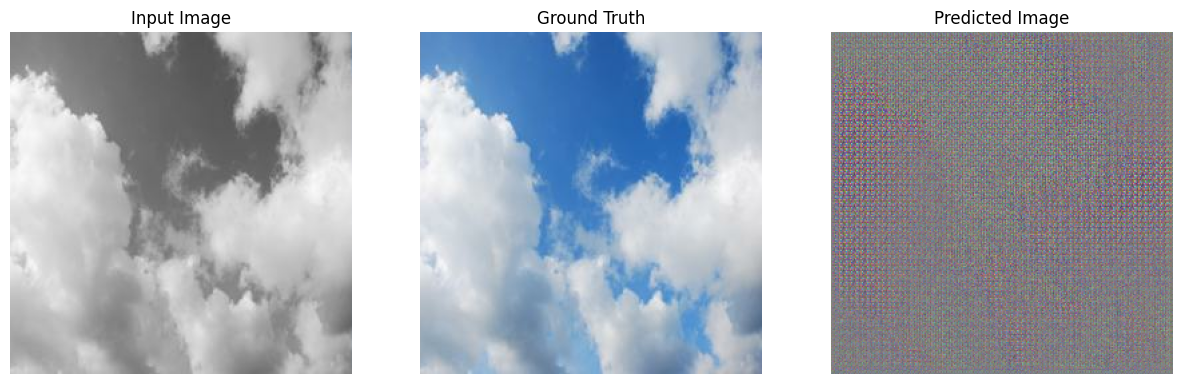

In [145]:
for example_input, example_target in val_dataset.take(1):
  generate_images(generator, example_input, example_target)


# Discriminator

In [146]:
# def Discriminator():
#   init = tf.random_normal_initializer(0., 0.02)

#   inp = layers.Input(shape=[256, 256, 3], name='input_image')
#   tar = layers.Input(shape=[256, 256, 3], name='target_image')
#   merged = layers.concatenate([inp, tar]) 

#   # C64
#   down1 = downsample(64, 4, False)(merged) 
#   # C128
#   down2 = downsample(128, 4)(down1) 
#   # C256
#   down3 = downsample(256, 4)(down2) 
#   # C512
#   zero_pad1 = layers.ZeroPadding2D()(down3) 
#   conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=init, use_bias=False)(zero_pad1) 
#   batchnorm1 = layers.BatchNormalization()(conv)
#   leaky_relu =layers.LeakyReLU()(batchnorm1)

#   # last
#   zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 
#   last = layers.Conv2D(1, 4, strides=1, kernel_initializer=init)(zero_pad2) 

#   return keras.Model(inputs=[inp, tar], outputs=last)

In [147]:
class Discriminator_(tf.keras.Model):
    def __init__(self,):
        super(Discriminator_, self).__init__()
        """Define the layers used in the network."""
        initializer = tf.random_normal_initializer(0., 0.02)
        self.down1 = downsample(64, 4, False)
        self.down2 = downsample(128, 4)
        self.down3 = downsample(256, 4)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                      kernel_initializer=initializer,
                                      use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                           kernel_initializer=initializer)

    def call(self, inputs, target, training=False):
        """Calculate the forward pass through the network."""
        x = tf.keras.layers.concatenate([inputs, target])
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last(x)


In [148]:
discriminator = Discriminator_()
discriminator.compile(loss="binary_crossentropy", optimizer= keras.optimizers.Adam(2e-4, beta_1=0.5))
# plot_model(discriminator, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
# discriminator.summary()

In [149]:
# disc_out = discriminator([inp[tf.newaxis,...], gen_output], training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()

In [150]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# accuracy_object = tf.keras.metrics.categorical_accuracy()

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss


In [151]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [152]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [153]:
EPOCHS = 4

def generate_images(model, test_input, tar, base_path='', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  """ Check the base path and make dir if needed."""
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()



In [154]:
@tf.function
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator(input_image, target, training=True)
    disc_generated_output = discriminator(input_image, gen_output, training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Update the metrics
  g_loss_metric.update_state(gen_loss)
  d_loss_metric.update_state(disc_loss)
  # accuracy_metric.update_state(tf.ones_like(gen_output), gen_output)
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))



In [155]:
def plot_losses(g_loss, d_loss, epoch, dataset):
    """Plot the losses each epoc during training."""
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig('results/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig('results/loss_tracking.png')
        plt.close()


In [156]:
def train(dataset, epochs):
  # Create the metrics
  g_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    # Reset the metrics
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    counter = 0
    for input_image, target in dataset:
      train_step(input_image, target, g_loss_metric, d_loss_metric)
      counter += 1
      if counter > 100:
        break
    # Get the metric results
    g_mean_loss = g_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    g_loss_log.append([g_mean_loss])
    d_loss_log.append([d_mean_loss])
    # mean_accuracy = accuracy_metric.result()
    #
    print('Epoch: ', epoch)
    print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))

    if (epoch) % 10 == 0:
      for i, (inp, tar) in enumerate(test_dataset.take(5)):
        generate_images(generator, inp, tar, base_path='results/{}'.format(i), epoch=epoch)
        plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset')

    # saving (checkpoint) the model every 20 epochs
    # if (epoch + 1) % 20 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

train(train_dataset, EPOCHS)



2023-05-30 00:53:30.176385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3645]
	 [[{{node Placeholder/_0}}]]
2023-05-30 00:53:30.177086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [3645]
	 [[{{node Placeholder/_0}}]]


Epoch:  0
  loss (g) (d) (g+d):     24.694, 1.490, 26.184


2023-05-30 00:57:22.664334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-30 00:57:22.665058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


Time taken for epoch 1 is 238.81634998321533 sec

Epoch:  1
  loss (g) (d) (g+d):     17.053, 1.296, 18.349
Time taken for epoch 2 is 226.4321734905243 sec

Epoch:  2
  loss (g) (d) (g+d):     15.484, 1.313, 16.797
Time taken for epoch 3 is 228.0454375743866 sec

Epoch:  3
  loss (g) (d) (g+d):     16.036, 1.262, 17.298
Time taken for epoch 4 is 206.7550687789917 sec



In [157]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [158]:
for inp, tar in test_dataset:
  generate_images(generator, inp, tar, base_path='results/0', epoch=4)


2023-05-30 01:08:30.488056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]
2023-05-30 01:08:30.488846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [100]
	 [[{{node Placeholder/_0}}]]


# GAN

In [ ]:
accuracy = tf.keras.metrics.CategoricalAccuracy()
discriminator = Discriminator()
generator = Generator()

In [ ]:
LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [ ]:
# class GAN(keras.Model):
  
#   def __init__(self,generator,discriminator, **kwargs):
#     super().__init__(**kwargs)
    
#     self.discriminator= discriminator
#     self.generator = generator
#     self.gan = self.build_combined_generator
    
#     self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")
#     self.gen_gan_loss_tracker = tf.keras.metrics.Mean(name="gen_gan_loss")
#     self.gen_total_loss_tracker = tf.keras.metrics.Mean(name="gen_total_loss")
#     self.gen_l1_loss_tracker = tf.keras.metrics.Mean(name="gen_l1_loss")

#   @property
#   def metrics(self):
#     return [
#         self.disc_loss_tracker,
#         self.gen_gan_loss_tracker,
#         self.gen_total_loss_tracker,
#         self.gen_l1_loss_tracker
#     ]

#   def build_combined_generator(self):
#     for layer in discriminator.layers:
#       if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = False

#     gan_input = layers.Input(shape=[256,256,3])
#     generator_output = generator(gan_input)
#     discriminator_output = discriminator([gan_input,generator_output])

#     gan = keras.Model(gan_input, [discriminator_output,generator_output])
#     return gan
  
#   def train_step(self,input_image, target):
#     with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
#         gen_output = self.generator(input_image, training=True)

#         disc_real_output = self.discriminator([input_image, target], training=True)
#         disc_generated_output = self.discriminator([input_image, gen_output], training=True)

#         gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
#         disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

#     generator_gradients = gen_tape.gradient(
#       gen_total_loss, self.generator.trainable_variables
#     )
#     discriminator_gradients = disc_tape.gradient(
#       disc_loss, self.discriminator.trainable_variables
#     )

#     self.generator_optimizer.apply_gradients(
#       zip(generator_gradients, generator.trainable_variables)
#     )
#     self.discriminator_optimizer.apply_gradients(
#       zip(discriminator_gradients, discriminator.trainable_variables)
#     )
#     # Report progress.
#     self.disc_loss_tracker.update_state(disc_loss)
#     self.gen_total_loss_tracker.update_state(gen_total_loss)
#     self.gen_gan_loss_tracker.update_state(gen_gan_loss)
#     self.gen_l1_loss_tracker.update_state(gen_l1_loss)
#     results = {m.name: m.result() for m in self.metrics}
#     return results

#   def test_step(self,input_image, target):
#     gen_output = generate_images(generator, input_image, target)
    
#     disc_real_output = discriminator([input_image, target], training=False)
#     disc_generated_output = discriminator([input_image, gen_output], training=False)
#     total_discriminator_loss = discriminator_loss(disc_real_output, disc_generated_output)
#     gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
#     # Report progress.
#     self.disc_loss_tracker.update_state(total_discriminator_loss)
#     self.gen_total_loss_tracker.update_state(gen_total_loss)
#     self.gen_gan_loss_tracker.update_state(gen_gan_loss)
#     self.gen_l1_loss_tracker.update_state(gen_l1_loss)
#     results = {m.name: m.result() for m in self.metrics}
#     return results
  


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
"""Sub class the Generator as well."""
class Generator_(tf.keras.Model):
    """docstring for Generator_."""
    def __init__(self,):
        super(Generator_, self).__init__()
        self.downsample = [downsample(64, 4, apply_batchnorm=False),
                           downsample(128, 4),  # (bs, 64, 64, 128)
                           downsample(256, 4),  # (bs, 32, 32, 256)
                           downsample(512, 4),  # (bs, 16, 16, 512)
                           downsample(512, 4),  # (bs, 8, 8, 512)
                           downsample(512, 4),  # (bs, 4, 4, 512)
                           downsample(512, 4),  # (bs, 2, 2, 512)
                           downsample(512, 4)]  # (bs, 1, 1, 512)

        self.upsample = [upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
                         upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
                         upsample(512, 4),  # (bs, 16, 16, 1024)
                         upsample(256, 4),  # (bs, 32, 32, 512)
                         upsample(128, 4),  # (bs, 64, 64, 256)
                         upsample(64, 4)]  # (bs, 128, 128, 128)

        initializer = tf.random_normal_initializer(0., 0.02)
        self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                                    strides=2,
                                                    padding='same',
                                                    kernel_initializer=initializer,
                                                    activation='tanh') # (bs, 256, 256, 3)
        self.concat = tf.keras.layers.Concatenate()

    def call(self, inputs, training=False):
        """Define the forward pass."""
        x = inputs
        # Downsampling through the model
        skips = []
        for down in self.downsample:
          x = down(x)
          skips.append(x)
        skips = reversed(skips[:-1])
        # Upsampling and establishing the skip connections
        for up, skip in zip(self.upsample, skips):
          x = up(x)
          x = self.concat([x, skip])
        return self.last(x)



# def Generator():
#   down_stack = [
#     downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
#     downsample(128, 4), # (bs, 64, 64, 128)
#     downsample(256, 4), # (bs, 32, 32, 256)
#     downsample(512, 4), # (bs, 16, 16, 512)
#     downsample(512, 4), # (bs, 8, 8, 512)
#     downsample(512, 4), # (bs, 4, 4, 512)
#     downsample(512, 4), # (bs, 2, 2, 512)
#     downsample(512, 4), # (bs, 1, 1, 512)
#   ]
#   up_stack = [
#     upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
#     upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
#     upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
#     upsample(512, 4), # (bs, 16, 16, 1024)
#     upsample(256, 4), # (bs, 32, 32, 512)
#     upsample(128, 4), # (bs, 64, 64, 256)
#     upsample(64, 4), # (bs, 128, 128, 128)
#   ]
#   initializer = tf.random_normal_initializer(0., 0.02)
#   last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
#                                          strides=2,
#                                          padding='same',
#                                          kernel_initializer=initializer,
#                                          activation='tanh') # (bs, 256, 256, 3)
#   concat = tf.keras.layers.Concatenate()
#   inputs = tf.keras.layers.Input(shape=[None,None,3])
#   x = inputs
#   # Downsampling through the model
#   skips = []
#   for down in down_stack:
#     x = down(x)
#     skips.append(x)
#   skips = reversed(skips[:-1])
#   # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     x = concat([x, skip])
#   x = last(x)
#   return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator_()

gen_output = generator(inp[tf.newaxis,...], training=False)
plt.imshow(gen_output[0,...])
plt.close()

"""## Build the Discriminator
  * The Discriminator is a PatchGAN.
  * Each block in the discriminator is (Conv -> BatchNorm -> Leaky ReLU)
  * The shape of the output after the last layer is (batch_size, 30, 30, 1)
  * Each 30x30 patch of the output classifies a 70x70 portion of the input image (such an architecture is called a PatchGAN).
  * Discriminator receives 2 inputs.
    * Input image and the target image, which it should classify as real.
    * Input image and the generated image (output of generator), which it should classify as fake.
    * We concatenate these 2 inputs together in the code (`tf.concat([inp, tar], axis=-1)`)
"""
"""
Build a class version of the discriminator here."""
class Discriminator_(tf.keras.Model):
    def __init__(self,):
        super(Discriminator_, self).__init__()
        """Define the layers used in the network."""
        initializer = tf.random_normal_initializer(0., 0.02)
        self.down1 = downsample(64, 4, False)
        self.down2 = downsample(128, 4)
        self.down3 = downsample(256, 4)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                      kernel_initializer=initializer,
                                      use_bias=False)
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu = tf.keras.layers.LeakyReLU()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                           kernel_initializer=initializer)

    def call(self, inputs, target, training=False):
        """Calculate the forward pass through the network."""
        x = tf.keras.layers.concatenate([inputs, target])
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.zero_pad1(x)
        x = self.conv(x)
        x = self.batchnorm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        return self.last(x)



# -----------------------------
# def Discriminator():
#   initializer = tf.random_normal_initializer(0., 0.02)
#
#   inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
#   tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
#
#   x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)
#
#   down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
#   down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
#   down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
#
#   zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
#   conv = tf.keras.layers.Conv2D(512, 4, strides=1,
#                                 kernel_initializer=initializer,
#                                 use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
#
#   batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
#
#   leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
#
#   zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
#
#   last = tf.keras.layers.Conv2D(1, 4, strides=1,
#                                 kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
#
#   return tf.keras.Model(inputs=[inp, tar], outputs=last)

discriminator = Discriminator_()
disc_out = discriminator(inp[tf.newaxis,...], gen_output, training=False)
# plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
# plt.colorbar()
# plt.show()

"""To learn more about the architecture and the hyperparameters you can refer the [paper](https://arxiv.org/abs/1611.07004).

## Define the loss functions and the optimizer

* **Discriminator loss**
  * The discriminator loss function takes 2 inputs; **real images, generated images**
  * real_loss is a sigmoid cross entropy loss of the **real images** and an **array of ones(since these are the real images)**
  * generated_loss is a sigmoid cross entropy loss of the **generated images** and an **array of zeros(since these are the fake images)**
  * Then the total_loss is the sum of real_loss and the generated_loss

* **Generator loss**
  * It is a sigmoid cross entropy loss of the generated images and an **array of ones**.
  * The [paper](https://arxiv.org/abs/1611.07004) also includes L1 loss which is MAE (mean absolute error) between the generated image and the target image.
  * This allows the generated image to become structurally similar to the target image.
  * The formula to calculate the total generator loss = gan_loss + LAMBDA * l1_loss, where LAMBDA = 100. This value was decided by the authors of the [paper](https://arxiv.org/abs/1611.07004).
"""

LAMBDA = 100

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# accuracy_object = tf.keras.metrics.categorical_accuracy()

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss
  return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

"""## Checkpoints (Object-based saving)"""

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
EPOCHS = 2

def generate_images(model, test_input, tar, base_path='', epoch=0):
  # the training=True is intentional here since
  # we want the batch statistics while running the model
  # on the test dataset. If we use training=False, we will get
  # the accumulated statistics learned from the training dataset
  # (which we don't want)
  """ Check the base path and make dir if needed."""
  if not os.path.exists(base_path):
    os.makedirs(base_path)

  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,8))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig(base_path + '/result_{}.png'.format(epoch))
  plt.close()



@tf.function
def train_step(input_image, target, g_loss_metric, d_loss_metric):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator(input_image, target, training=True)
    disc_generated_output = discriminator(input_image, gen_output, training=True)

    gen_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  # Update the metrics
  g_loss_metric.update_state(gen_loss)
  d_loss_metric.update_state(disc_loss)
  # accuracy_metric.update_state(tf.ones_like(gen_output), gen_output)
  generator_gradients = gen_tape.gradient(gen_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))




In [ ]:
def train(dataset, epochs):
  # Create the metrics
  g_loss_log = []
  d_loss_log = []
  g_loss_metric = tf.keras.metrics.Mean(name='g_train_loss')
  d_loss_metric = tf.keras.metrics.Mean(name='d_train_loss')
  accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
  for epoch in range(epochs):
    start = time.time()
    # Reset the metrics
    g_loss_metric.reset_states()
    d_loss_metric.reset_states()
    counter = 0
    for input_image, target in dataset:
      train_step(input_image, target, g_loss_metric, d_loss_metric)
      counter += 1
      if counter > 100:
        break
    # Get the metric results
    g_mean_loss = g_loss_metric.result()
    d_mean_loss = d_loss_metric.result()
    g_loss_log.append([g_mean_loss])
    d_loss_log.append([d_mean_loss])
    # mean_accuracy = accuracy_metric.result()
    #
    print('Epoch: ', epoch)
    print('  loss (g) (d) (g+d):     {:.3f}, {:.3f}, {:.3f}'.format(g_mean_loss, d_mean_loss, g_mean_loss + d_mean_loss))

    if (epoch) % 10 == 0:
      for i, (inp, tar) in enumerate(test_dataset.take(5)):
        generate_images(generator, inp, tar, base_path='results/{}'.format(i), epoch=epoch)
        plot_losses(g_loss_log, d_loss_log, epoch=epoch, dataset='dataset')

    # saving (checkpoint) the model every 20 epochs
    # if (epoch + 1) % 20 == 0:
    #   checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))

train(train_dataset, EPOCHS)



In [ ]:
def gan(generator,discriminator):
    for layer in discriminator.layers:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

    gan_input = layers.Input(shape=[256,256,3])
    generator_output = generator(gan_input)
    discriminator_output = discriminator([gan_input,generator_output])

    gan = keras.Model(gan_input, [discriminator_output,generator_output])
    return gan

In [ ]:
gan = gan(generator,discriminator)
gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),loss_weights=[1,100],metrics=['accuracy'])
plot_model(gan, to_file='gan_model_plot.png', show_shapes=True, show_layer_names=True)
gan.summary()

In [ ]:
def plot_losses(g_loss, d_loss, epoch, dataset):
    """Plot the losses each epoc during training."""
    total_loss = [g[0].numpy() + d[0].numpy() for g, d in zip(g_loss, d_loss)]
    g_loss = [g[0].numpy() for g in g_loss]
    d_loss = [d[0].numpy() for d in d_loss]
    plt.figure(figsize=(10,5))
    plt.plot(g_loss, label='gen')
    plt.plot(d_loss, label='disc')
    plt.plot(total_loss, label='total')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('training loss')
    plt.savefig('results/losses.png')
    plt.close()

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
    xs = [_ for _ in range(len(d_loss))]
    if len(xs) > 20:
        window=5
        f, axarr = plt.subplots(2, figsize=(8,4), sharex=True)
        axarr[0].plot(d_loss, alpha=0.4, linewidth=5)
        axarr[0].plot(xs[window:-window], smooth(d_loss, window)[window:-window], c='C0')
        axarr[0].set_title('Discriminator')
        axarr[0].set_yscale('log')
        axarr[0].set_ylabel('loss')
        axarr[1].plot(g_loss, alpha=0.4, linewidth=5)
        axarr[1].plot(xs[window:-window], smooth(g_loss, window)[window:-window], c='C1')
        axarr[1].set_title('Generator')
        axarr[1].set_xlabel('Epoch')
        axarr[1].set_ylabel('loss')
        plt.savefig('results/loss_tracking.png')
        plt.close()



In [ ]:
history = gan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[GanMonitor(val_dataset, BATCH_SIZE)],
)

# Loss function

# Training

In [ ]:

EPOCHS = 

In [ ]:
class GanMonitor(keras.callbacks.Callback):
    def __init__(self, val_dataset, n_samples, epoch_interval=5):
        self.val_images = next(iter(val_dataset))
        self.n_samples = n_samples
        self.epoch_interval = epoch_interval

    def infer(self):
        latent_vector = tf.random.normal(
            shape=(self.model.batch_size, self.model.latent_dim), mean=0.0, stddev=2.0
        )
        return self.model.predict([latent_vector, self.val_images[2]])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            generated_images = self.infer()
            for _ in range(self.n_samples):
                grid_row = min(generated_images.shape[0], 3)
                f, axarr = plt.subplots(grid_row, 3, figsize=(18, grid_row * 6))
                for row in range(grid_row):
                    ax = axarr if grid_row == 1 else axarr[row]
                    ax[0].imshow((self.val_images[0][row] + 1) / 2)
                    ax[0].axis("off")
                    ax[0].set_title("Mask", fontsize=20)
                    ax[1].imshow((self.val_images[1][row] + 1) / 2)
                    ax[1].axis("off")
                    ax[1].set_title("Ground Truth", fontsize=20)
                    ax[2].imshow((generated_images[row] + 1) / 2)
                    ax[2].axis("off")
                    ax[2].set_title("Generated", fontsize=20)
                plt.show()


In [ ]:
history = gan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[GanMonitor(val_dataset, BATCH_SIZE)],
)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("disc_loss")
plot_history("gen_loss")
plot_history("feat_loss")
plot_history("vgg_loss")
plot_history("kl_loss")

In [ ]:

def train(train_dataset, val_dataset, epochs):
  
  for epoch in range(epochs):
    start = time.time()

    for input_image, target in tqdm(train_dataset):
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

      generator_gradients = gen_tape.gradient(gen_total_loss,
                                              generator.trainable_variables)
      discriminator_gradients = disc_tape.gradient(disc_loss,
                                                  discriminator.trainable_variables)

      generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))

      with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

      

    for inp, tar in val_dataset.take(10):
        generate_images(generator, inp, tar)
        clear_output(wait=True)

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))

In [ ]:
train(train_dataset, val_dataset, EPOCHS)

In [ ]:
if not os.path.exists(PATH_GENERATOR):
  os.makedirs(PATH_GENERATOR)
generator.save(PATH_GENERATOR+'generator_final.h5')

In [ ]:
if not os.path.exists(PATH_GENERATOR):
  os.makedirs(PATH_GENERATOR)
discriminator.save(PATH_GENERATOR+'discriminator_final.h5')

In [ ]:
for inp, tar in test_dataset.take(50):
  generate_images(generator, inp, tar)

In [ ]:
new_model = keras.models.load_model(PATH_GENERATOR+'final.h5')

for inp, tar in test_dataset.take(10):
  generate_images(new_model, inp, tar)

In [ ]:
plt.plot(generator_loss)

In [ ]:
discriminator.summary()

In [ ]:
def create_gan(generator, discriminator):
    discriminator.trainable = False

    gan_input = tf.keras.layers.Input(shape=[256,256,3])
    generator_output = generator(gan_input)
    gan_output = discriminator(generator_output)

    gan = tf.keras.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

    gan.summary()
    discriminator.trainable = True
    return gan

In [ ]:
def save(gan, generator, discriminator):
    discriminator.trainable = False
    gan.save('gan.h5')
    discriminator.trainable = True
    generator.save('generator.h5')
    discriminator.save('discriminator.h5')


def load():
    discriminator = keras.models.load_model('discriminator.h5')
    generator = keras.models.load_model('generator.h5')
    gan = keras.models.load_model('gan.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

In [ ]:
save(gan,generator,discriminator)

In [ ]:
new_gan, new_generator, new_discriminator = load()